In [ ]:
import csv
import numpy as np
import random
import torch
import torch.utils.data
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter

In [ ]:
header = ['age', 'work', 'fnlwgt', 'edu', 'yredu', 'marriage', 'occupation',
 'relationship', 'race', 'sex', 'capgain', 'caploss', 'workhr', 'country']
df = pd.read_csv(
    "https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data",
    names=header,
    index_col=False)
df.shape # there are 32561 rows (records) in the data frame, and 14 columns (features)

(32561, 14)

Part 1A

In [ ]:
subdf = df[["age", "yredu", "capgain", "caploss", "workhr"]]
print(np.min(subdf))   #Minimun
print(np.max(subdf))   #Maximum
print(np.mean(subdf))  #average

age        17
yredu       1
capgain     0
caploss     0
workhr      1
dtype: int64
age           90
yredu         16
capgain    99999
caploss     4356
workhr        99
dtype: int64
age          38.581647
yredu        10.080679
capgain    1077.648844
caploss      87.303830
workhr       40.437456
dtype: float64


In [ ]:
for feature in ["age", "yredu", "capgain", "caploss", "workhr"]:
    df[feature] = (df[feature]-np.min(df[feature]))/(np.max(df[feature])-np.min(df[feature]))
print(df["workhr"])

Part 1B

In [ ]:
print("Male Percentage", sum(df["sex"] == " Male")/(sum(df["sex"] == " Male")+sum(df["sex"] == " Female")))
print("Female Percentage", sum(df["sex"] == " Female")/(sum(df["sex"] == " Male")+sum(df["sex"] == " Female")))

Male Percentage 0.6692054912318418
Female Percentage 0.33079450876815825


Part 1C

In [ ]:
contcols = ["age", "yredu", "capgain", "caploss", "workhr"]
catcols = ["work", "marriage", "occupation", "edu", "relationship", "sex"]
features = contcols + catcols
df = df[features]

missing = pd.concat([df[c] == " ?" for c in catcols], axis=1).any(axis=1)
df_with_missing = df[missing]
df_not_missing = df[~missing]

print(df_with_missing.shape)   #1843 records have missing features
print((df_with_missing.shape[0]/df.shape[0])*100 , "% of records are removed")

(1843, 11)
5.660145572924664 % of records are removed


Part 1D

In [ ]:
set(df_not_missing["work"])

{' Federal-gov',
 ' Local-gov',
 ' Private',
 ' Self-emp-inc',
 ' Self-emp-not-inc',
 ' State-gov',
 ' Without-pay'}

Part 1E

In [ ]:
data = pd.get_dummies(df_not_missing)
data.shape                      #There are 57 columns in data
data[0:3]                       # increased to 57 because the categorical variables are all converted into 0 or 1 

,age,yredu,capgain,caploss,workhr,work_ Federal-gov,work_ Local-gov,work_ Private,work_ Self-emp-inc,work_ Self-emp-not-inc,work_ State-gov,work_ Without-pay,marriage_ Divorced,marriage_ Married-AF-spouse,marriage_ Married-civ-spouse,marriage_ Married-spouse-absent,marriage_ Never-married,marriage_ Separated,marriage_ Widowed,occupation_ Adm-clerical,occupation_ Armed-Forces,occupation_ Craft-repair,occupation_ Exec-managerial,occupation_ Farming-fishing,occupation_ Handlers-cleaners,occupation_ Machine-op-inspct,occupation_ Other-service,occupation_ Priv-house-serv,occupation_ Prof-specialty,occupation_ Protective-serv,occupation_ Sales,occupation_ Tech-support,occupation_ Transport-moving,edu_ 10th,edu_ 11th,edu_ 12th,edu_ 1st-4th,edu_ 5th-6th,edu_ 7th-8th,edu_ 9th,edu_ Assoc-acdm,edu_ Assoc-voc,edu_ Bachelors,edu_ Doctorate,edu_ HS-grad,edu_ Masters,edu_ Preschool,edu_ Prof-school,edu_ Some-college,relationship_ Husband,relationship_ Not-in-family,relationship_ Other-relative,relationship_ Own-child,relationship_ Unmarried,relationship_ Wife,sex_ Female,sex_ Male
0,0.301370,0.800000,0.02174,0.0,0.397959,0,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1
1,0.452055,0.800000,0.00000,0.0,0.122449,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1
2,0.287671,0.533333,0.00000,0.0,0.397959,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1


Part 1F

In [ ]:
datanp = data.values.astype(np.float32)

cat_index = {}  # Mapping of feature -> start index of feature in a record
cat_values = {} # Mapping of feature -> list of categorical values the feature can take

# build up the cat_index and cat_values dictionary
for i, header in enumerate(data.keys()):
    if "_" in header: # categorical header
        feature, value = header.split()
        feature = feature[:-1] # remove the last char; it is always an underscore
        if feature not in cat_index:
            cat_index[feature] = i
            cat_values[feature] = [value]
        else:
            cat_values[feature].append(value)

def get_onehot(record, feature):
  
    start_index = cat_index[feature]
    stop_index = cat_index[feature] + len(cat_values[feature])
    return record[start_index:stop_index]

def get_categorical_value(onehot, feature):
    """
    Return the categorical value name of a feature given
    a one-hot vector representing the feature.
    
    Args:
        - onehot: a numpy array one-hot representation of the feature
        - feature: a string, should be an element of `catcols`
        
    Examples:
    
    >>> get_categorical_value(np.array([0., 0., 0., 0., 0., 1., 0.]), "work")
    'State-gov'
    >>> get_categorical_value(np.array([0.1, 0., 1.1, 0.2, 0., 1., 0.]), "work")
    'Private'
    """
    max = onehot.argmax(axis=0)
    return cat_values[feature][max]

def get_feature(record, feature):
    """
    Return the categorical feature value of a record
    """
    onehot = get_onehot(record, feature)
    return get_categorical_value(onehot, feature)

def get_features(record):
    """
    Return a dictionary of all categorical feature values of a record
    """
    return { f: get_feature(record, f) for f in catcols }

In [ ]:
get_categorical_value(np.array([0., 0., 0., 0., 0., 1., 0.]), "work")

'State-gov'

In [ ]:
print(cat_index)
print(cat_values)

{'work': 5, 'marriage': 12, 'occupation': 19, 'edu': 33, 'relationship': 49, 'sex': 55}
{'work': ['Federal-gov', 'Local-gov', 'Private', 'Self-emp-inc', 'Self-emp-not-inc', 'State-gov', 'Without-pay'], 'marriage': ['Divorced', 'Married-AF-spouse', 'Married-civ-spouse', 'Married-spouse-absent', 'Never-married', 'Separated', 'Widowed'], 'occupation': ['Adm-clerical', 'Armed-Forces', 'Craft-repair', 'Exec-managerial', 'Farming-fishing', 'Handlers-cleaners', 'Machine-op-inspct', 'Other-service', 'Priv-house-serv', 'Prof-specialty', 'Protective-serv', 'Sales', 'Tech-support', 'Transport-moving'], 'edu': ['10th', '11th', '12th', '1st-4th', '5th-6th', '7th-8th', '9th', 'Assoc-acdm', 'Assoc-voc', 'Bachelors', 'Doctorate', 'HS-grad', 'Masters', 'Preschool', 'Prof-school', 'Some-college'], 'relationship': ['Husband', 'Not-in-family', 'Other-relative', 'Own-child', 'Unmarried', 'Wife'], 'sex': ['Female', 'Male']}


Part 1G

In [ ]:
np.random.seed(50)
print(datanp.shape)
np.random.shuffle(datanp)
train_set = datanp[:int(30718*0.7)]
val_set = datanp[int(30718*0.7):int(30718*0.85)]
test_set = datanp[int(30718*0.85):30718]
print(train_set.shape[0]) #21502
print(val_set.shape[0]) #4608
print(test_set.shape[0]) #4608

(30718, 57)
21502
4608
4608


Part 2A

In [ ]:
from torch import nn

class AutoEncoder(nn.Module):
    def __init__(self):
        super(AutoEncoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(57, 57), # TODO -- FILL OUT THE CODE HERE!
            nn.ReLU(),
            nn.Linear(57,30),
            nn.ReLU(),
            nn.Linear(30,11)
        )
        self.decoder = nn.Sequential(
            nn.Linear(11,30),
            nn.ReLU(),
            nn.Linear(30,57),
            nn.ReLU(),
            nn.Linear(57, 57), # TODO -- FILL OUT THE CODE HERE!
            nn.Sigmoid() # get to the range (0, 1)
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

Part 2B: This is because we need the output to be in range 0 to 1, since "data" has been normalized so that all data are in the range 0 to 1. By adding sigmoid, the model would produce a result in the same range as data

Part 3A

In [ ]:
def zero_out_feature(records, feature):
    """ Set the feature missing in records, by setting the appropriate
    columns of records to 0
    """
    start_index = cat_index[feature]
    stop_index = cat_index[feature] + len(cat_values[feature])
    records[:, start_index:stop_index] = 0
    return records

def zero_out_random_feature(records):
    """ Set one random feature missing in records, by setting the 
    appropriate columns of records to 0
    """
    return zero_out_feature(records, random.choice(catcols))

def get_accuracy(model, data_loader):
    """Return the "accuracy" of the autoencoder model across a data set.
    That is, for each record and for each categorical feature, 
    we determine whether the model can successfully predict the value
    of the categorical feature given all the other features of the 
    record. The returned "accuracy" measure is the percentage of times 
    that our model is successful.
        
    Args:
       - model: the autoencoder model, an instance of nn.Module
       - data_loader: an instance of torch.utils.data.DataLoader

    Example (to illustrate how get_accuracy is intended to be called.
             Depending on your variable naming this code might require
             modification.)

        >>> model = AutoEncoder()
        >>> vdl = torch.utils.data.DataLoader(data_valid, batch_size=256, shuffle=True)
        >>> get_accuracy(model, vdl)
    """
    total = 0
    acc = 0
    for col in catcols:
        for item in data_loader: # minibatches
            inp = item.detach().numpy()
            out = model(zero_out_feature(item.clone(), col)).detach().numpy()
            for i in range(out.shape[0]): # record in minibatch
                acc += int(get_feature(out[i], col) == get_feature(inp[i], col))
                total += 1
    return acc / total

def train(model, train_loader, valid_loader, num_epochs=70, learning_rate=1e-3):
    """ Training loop. You should update this."""
    train_loss = np.zeros(num_epochs)
    val_loss = np.zeros(num_epochs)
    train_acc= np.zeros(num_epochs)
    val_acc= np.zeros(num_epochs)
    torch.manual_seed(42)
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    for epoch in range(num_epochs):
      total_train_loss = 0.0
      total_val_loss = 0.0
      for i, data in enumerate(train_loader):
            datam = zero_out_random_feature(data.clone()) # zero out one categorical feature
            recon = model(datam)
            loss = criterion(recon, data)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            total_train_loss += loss.item()
      train_loss[epoch] = float(total_train_loss) / (i+1)
        
      for i, data in enumerate(valid_loader):
            datam = zero_out_random_feature(data.detach().clone()) # zero out one categorical feature
            recon = model(datam).detach()
            loss = criterion(recon, data)
            total_val_loss += loss.item()
      val_loss[epoch] = total_val_loss/(i+1)
      train_acc[epoch] = get_accuracy(model, train_loader)
      val_acc[epoch] = get_accuracy(model, val_loader)
        
    plt.title("Train vs Validation Loss")
    plt.plot(range(1,num_epochs+1), train_loss, label="Train")
    plt.plot(range(1,num_epochs+1), val_loss, label="Validation")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend(loc='best')
    plt.show()
    
    plt.title("Train vs Validation Accuracy")
    plt.plot(range(1,num_epochs+1), train_acc, label="Train")
    plt.plot(range(1,num_epochs+1), val_acc, label="Validation")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend(loc='best')
    plt.show()

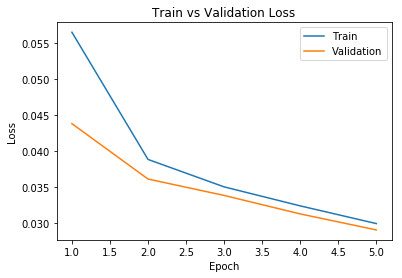

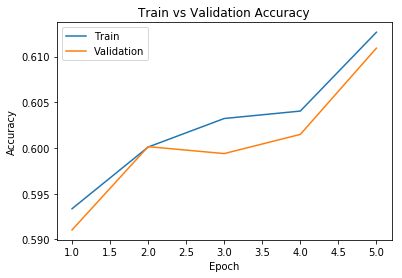

In [ ]:
train_loader = torch.utils.data.DataLoader(train_set)
val_loader = torch.utils.data.DataLoader(val_set)
model = AutoEncoder()
train(model,train_loader,val_loader)

Part 3C

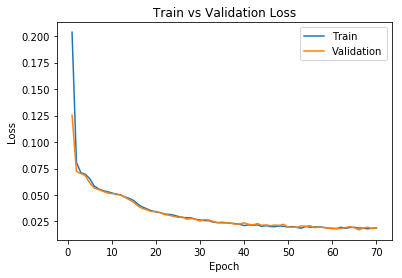

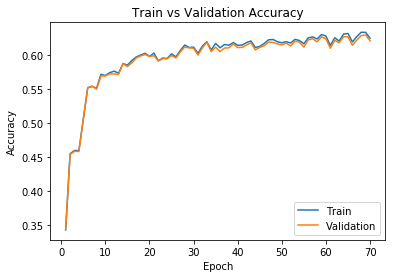

In [ ]:
train_loader = torch.utils.data.DataLoader(train_set, batch_size=512, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_set, batch_size=512, shuffle=True)
model = AutoEncoder()
train(model,train_loader,val_loader)  #num_epochs=70, learning_rate=0.001, batch_size=512, shuffle=True

Part 3D

**Optimizer Related Hyperparameters tuning:**

Tuning Learning rate:  lr @ 0.0001 is stable however the step is too small in my opinion, changed to 0.001, the curve looked better, changed to 0.01, the curve looked noisy. 

Tuning Batch size:  bs = 64, accuracy is lower than now(512), bs = 128, still lower, bs=256, accuracy got better but still not as good as 512.

Tuning Number of Epochs: Epoch = 10, underfit, Epoch = 30, still underfit. So I increased to 70 and got the curve above.

Final set : bs = 512, epoch=70, lr=0.001

**Non-Optimizer Related Hyperparameters tuning:**

Changing the model number of layers: 

3 layers: good results. 
Tried 4 layers to see if it could produce better results - no observable improvements, increased computational time.
Tried 2 layers to see if it could get the same results as 3 layers - 2 layers performed poorly. 

Changing the # of neurons in the embedding space:

First attempt was 11 since there were 11 features, it was fine, test accuracy = 61.69%

Second attempt was 15, test accuracy = 61.22%

Then Tried 20, test accuracy = 60.88%

Then tried 5 and 10, not as good as 11 in terms of loss. Tried 15 and 20, and 15 had better accuracy and loss.

Final set: # neurons in the embedding space:11, # of layer: 3 for encoder and decoder




Part 4A

In [ ]:
test_loader = torch.utils.data.DataLoader(test_set)
print(get_accuracy(model,test_loader))   #test accuracy = 61.69%

0.6168619791666666


Part 4B :

In [ ]:
prob = 0
for i in cat_values:
  df_1 = df[i] 
  count = Counter(df_1)
  number = count.most_common(1)           
  prob += number[0][1] / df.shape[0]     
  
acc = prob/len(cat_values)               # get the average baseline accuracy
print(acc)

0.4468331234708189


4C: It is higher than the baseline accuracy, which means that my model is working well. ( at least better than baseline model)

Part 4D:  Yes, it is possible because education level is related to occupation, work hour, age, and year of education. Based on the seen data, it is not hard to guess that this person has a high education level.

In [ ]:
df[int(30718*0.85):26111]

,age,yredu,capgain,caploss,workhr,work,marriage,occupation,edu,relationship,sex
26110,0.465753,0.933333,0.278283,0.0,0.602041,Self-emp-inc,Divorced,Prof-specialty,Prof-school,Not-in-family,Male


Part 4E (Bachelors. Almost!)

In [ ]:

test_row = zero_out_feature(datanp[int(30718*0.85):26111],'edu')
loader = torch.utils.data.DataLoader(test_row)
for i in loader:
    output = model(i)   
get_feature(output.detach().numpy()[0], 'edu')

'Bachelors'

Part 4F : The base line model would guess HS-Grad since it appeared most in the dataset.

In [ ]:
prob = 0
for i in cat_values:
  df_1 = df[i] 
  count = Counter(df_1)
  number = count.most_common(1)           
  prob = number    
  print(i,prob)    


work [(' Private', 22696)]
marriage [(' Married-civ-spouse', 14976)]
occupation [(' Prof-specialty', 4140)]
edu [(' HS-grad', 10501)]
relationship [(' Husband', 13193)]
sex [(' Male', 21790)]
